## Fitting with our dataset

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import gepard as g # NeuralModel with Dispersion relation added 
from gepard import model, fitter, data, plots
import gepard.plots as gplot
from gepard.fits import GLO15new, AUTIpts, ALUIpts, ACpts, AULpts, ALLpts
print('Gepard version = {}'.format(g.__version__))

Gepard version = 0.9.11b0


In [3]:
import gmaster as gm
from gmaster.fits import th_KM15, th_KM10b # need KM15 for simulated data
th15 = th_KM15
from gmaster.constants import Mp2, toTeX

In [4]:
import torch
import numpy as np 
#np.set_printoptions(legacy='1.25')
import matplotlib
import matplotlib.pyplot as plt
import shelve, logging, copy
logging.basicConfig(level=logging.ERROR) 
import pandas as pd 
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import norm

### To add our data files to gepard


In [5]:
sys.path.append('/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/')

import mydatafiles
from mydatafiles import ep2epgamma

mydset = g.data.loaddata(mydatafiles)
mydset.update(g.data.loaddata(ep2epgamma))

In [6]:
# To have nice LaTeX fonts on plots
plt.rc('text', usetex=True)
params = {'text.latex.preamble' : '\n'.join([r'\usepackage{amssymb}', r'\usepackage{amsmath}'])}
plt.rcParams.update(params)

In [7]:
#HallA15_XLUw = g.dset.get(117,[])
#HallA15_XLUw = [data.dset[117]] 
#fitpoints = (HallA15_XLUw)
#g.describe_data(fitpoints)

In [8]:
HallA15_XLUw = g.dset.get(117,[])
HallA15w = g.dset.get(117,[]) + g.dset.get(116,[])[:15] + g.dset.get(116,[])[15:] # 2015(BSDw+BSSw)
HallA17w = g.dset.get(135,[]) + g.dset.get(136,[])[:22] + g.dset.get(136,[])[22:] # 2017(BSDw+BSSw)

HallA6w = g.dset.get(50, []) + g.dset.get(51, []) + g.dset.get(105, []) # 2006(BSDw_byDM+BSSw+BSDovBSS)

In [9]:
fitpoints = (
    g.dset.get(101, []) + g.dset.get(102, []) + g.dset.get(8, [])  
    + g.dset.get(81, []) + g.dset.get(94, []) + g.dset.get(95, []) + g.dset.get(96, [])
    + mydset.get(150, [])   # + mydset.get(182, []) + mydset.get(192, []) 
    #+ ACpts+ AULpts + ALLpts  # HERMES
    # + mydset.get(251, []) # TSApre CLAS
    # HallA6w  # 2006(BSDw_byDM+BSSw+BSDovBSS)
    # g.dset.get(117, []) + g.dset.get(116, []) + g.dset.get(135, []) + g.dset.get(136, []) + g.dset.get(145, []) # 2015(BSDw+BSSw), 2017(BSDw+BSSw+X)  ##HallA
    # HallA15_XLUw + HallA15w + HallA17w
    # + g.dset.get(143, []) + g.dset.get(144, []) # 2018(BSSw+BSDw) Neutron or deuteron?
)   
g.describe_data(fitpoints)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
80 x ALU     CLAS    -1     150 arXiv:2211.11274
10 x ALU     CLAS    -1     94  arXiv:1501.07052
12 x ALU     CLAS    -1.0   8   arXiv:0711.4805
 6 x ALU     CLAS    -1.0   81  arXiv:0812.2950
 6 x ALU     CLAS    -2.0   81  arXiv:0812.2950
10 x BTSA    CLAS    0.0    96  arXiv:1501.07052
10 x BTSA    CLAS    1.0    96  arXiv:1501.07052
10 x TSA     CLAS    -1     95  arXiv:1501.07052
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------
TOTAL = 288


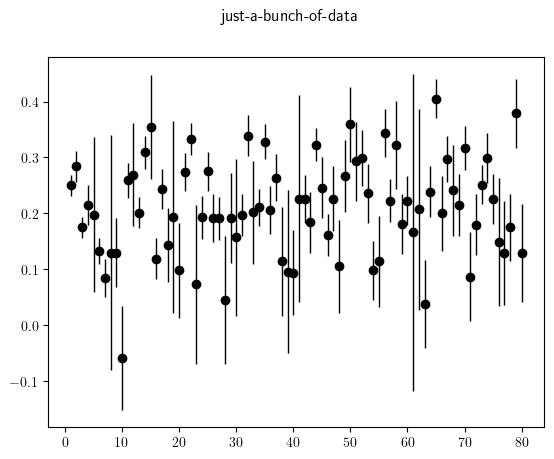

In [10]:
fig = gplot.jbod(points=mydset[150])

In [16]:
# For easier manipulations we transform some datasets to pandas frames
data = mydset[150]
BSA = data.df()   # ALU by CLAS 2022
data = g.dset[102]
BSS = data.df()  # CLAS 2015
data = g.dset[101]
BSD = data.df()  # CLAS 2015

In [12]:
data = g.dset[103]
BSA = data.df()   # ALU by HallA 2006 (BSDovBSS)
data = g.dset[55]
BSD = data.df()  # BSDw by HallA 2006
data = g.dset[51]
BSS = data.df()  # BSSw by HallA 2006


In [17]:
# Bins can be defined as ranges within the following limiting values:
tmlims = [0, 0.13, 0.18, 0.22, 0.3, 0.4, 0.5, 0.7]
xilims = [0, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21, 0.23, 0.26, 0.29, 0.32]  

Text(0, 0.5, '$-t\\quad[{\\rm GeV}^2]$')

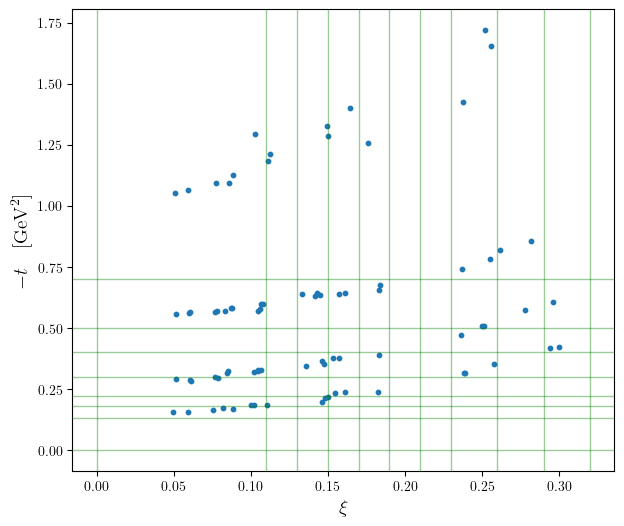

In [18]:
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSA.xi, BSA.tm, s=10)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)

Text(0, 0.5, '$-t\\quad[{\\rm GeV}^2]$')

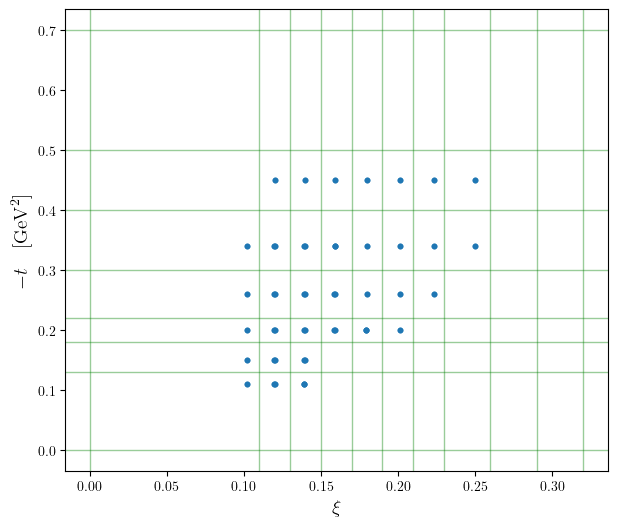

In [19]:
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSS.xi, BSS.tm, s=10)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)

## Fit with NeuralModel

In [20]:
class NNTest(g.model.NeuralModel, g.eff.DipoleEFF, g.dvcs.BM10):    

    def build_net(self):
            '''Overriding the default architecture and optimizer'''
            nn_model = torch.nn.Sequential(
                    torch.nn.Linear(2, 23),
                    torch.nn.ReLU(),
                    torch.nn.Linear(23, 37),
                    torch.nn.ReLU(),
                    torch.nn.Linear(37, 19),
                    torch.nn.ReLU(),
                    torch.nn.Linear(19, len(self.output_layer))
                )
            optimizer = torch.optim.Rprop(nn_model.parameters(), lr=0.01 ) #lr=0.05 #2e-3
            return nn_model, optimizer

In [21]:
th = NNTest(output_layer=['ImH', 'ReH']) # , q2in=True) q2in not implemented yet
print(th.useDR)

None


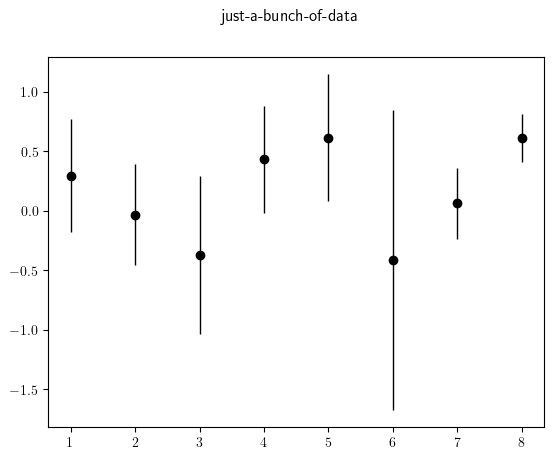

In [22]:
fig = gplot.jbod(points=mydset[192]) #mydset[182]

In [ ]:
f = g.fitter.NeuralFitter(fitpoints, th, nnets=5, nbatch=10, batchlen=3, regularization='L1', lx_lambda=0.0001)
#f = g.fitter.NeuralFitter(fitpoints, th, nnets=5 ,batchlen=10, regularization='L2', lx_lambda=0.002)
f.fit()


Epoch   3: train error = 14.2397 test error = 11.5092 -

In [33]:
th.chisq(fitpoints)

(np.float64(253.4026535430698), 289, np.float64(0.9355177511790146))

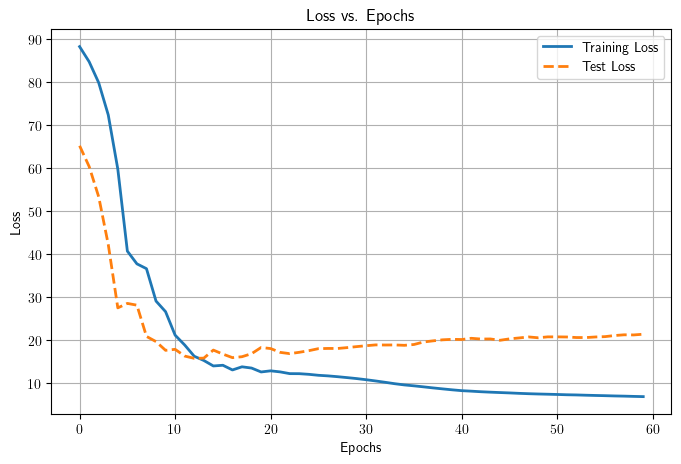

In [68]:
# Plot the results:
plt.figure(figsize=(8, 5))
plt.plot(f.history, label="Training Loss",linewidth=2.0)
plt.plot(f.test_history, label="Test Loss", linestyle="dashed",linewidth=2.0)
plt.xlabel("Epochs") #Epochs in nbatch length
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()
plt.grid()
plt.show()

### Just a bunch of data with mydataset

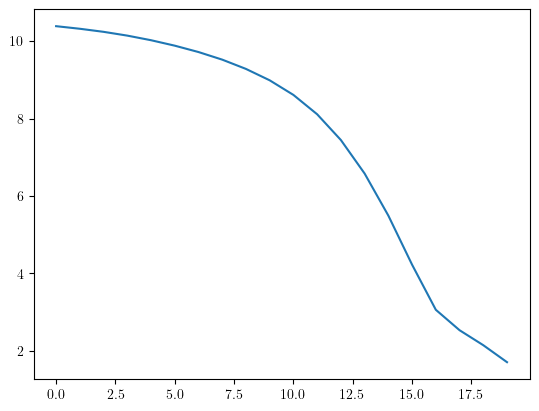

Fit on CLAS data


In [ ]:
#plt.figure()
#plt.plot(f.history)
#plt.show()
#th.name = "Fit on CLAS data"
#print(th.name)

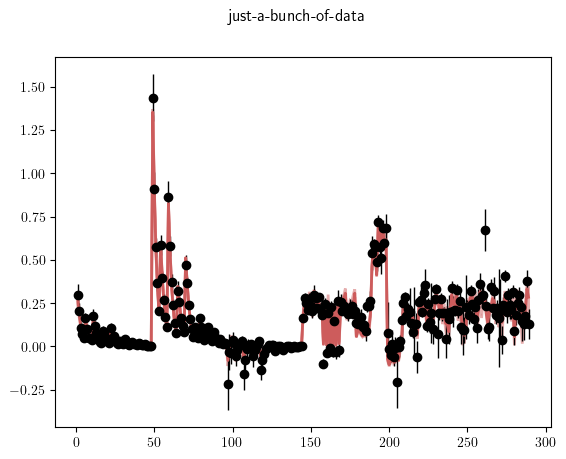

In [34]:
fig = gplot.jbod(points=fitpoints, lines=[th], bands=[th])

### CFFs plots in the no DR case

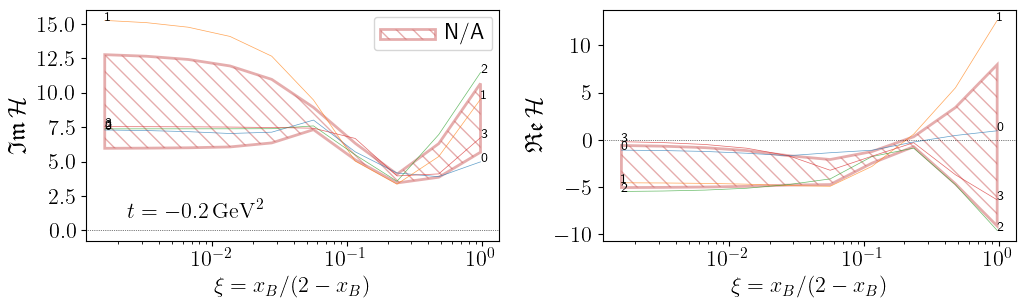

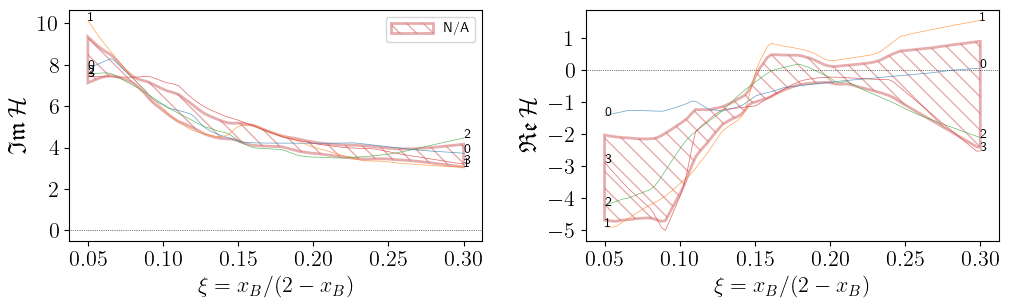

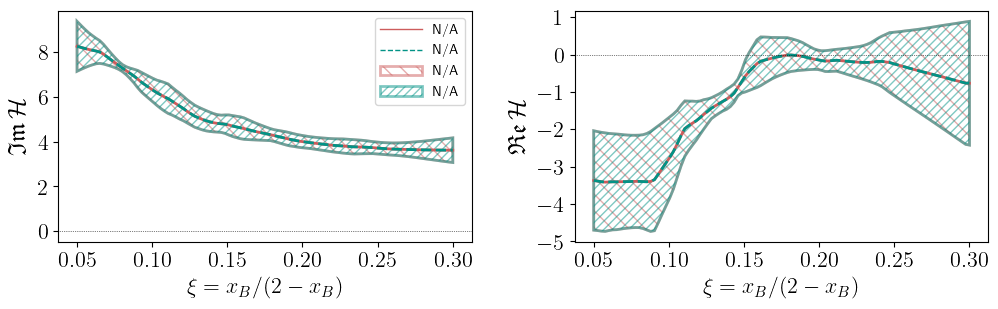

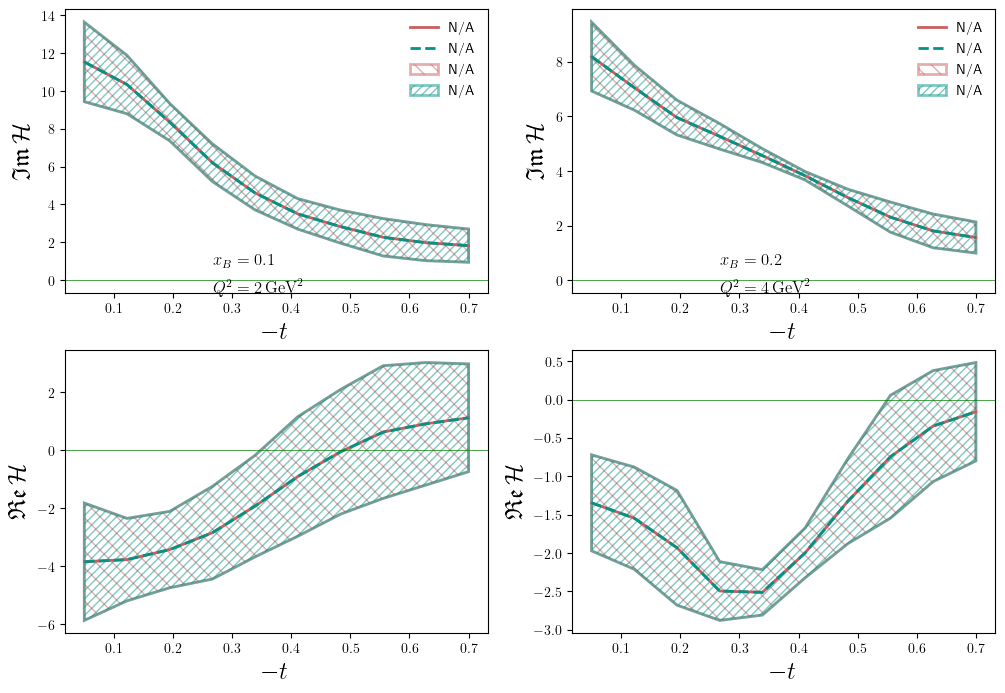

In [35]:
fig = gplot.CFF3log(cffs=['ImH', 'ReH'],  mesh=th, bands=[th], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  mesh=th, bands=[th])
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  lines=[th, th], bands=[th, th])
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=[th, th], bands=[th, th])

In [71]:
th2 = NNTest(output_layer=['ImH', 'ReH', 'ImE', 'ReE']) 

In [72]:
f = g.fitter.NeuralFitter(fitpoints, th2, nnets=5, batchlen=10, regularization='L2', lx_lambda=0.002)
f.fit()


Epoch  10: train error = 14.5804 test error = 31.7407 -
Epoch  20: train error = 11.5128 test error = 13.1802 -
Epoch  30: train error = 5.2321 test error = 4.4750 -
Epoch  40: train error = 3.1840 test error = 3.1393 -
Epoch  50: train error = 1.7128 test error = 3.1805 +
Epoch  60: train error = 1.2757 test error = 3.2958 +
Epoch  70: train error = 1.1537 test error = 3.4249 +
Epoch  80: train error = 1.0698 test error = 3.4079 +
Epoch  90: train error = 0.9780 test error = 3.4511 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 3.139312201421591

Epoch  10: train error = 19.4563 test error = 19.4176 -
Epoch  20: train error = 5.6398 test error = 7.9075 -
Epoch  30: train error = 4.0446 test error = 5.9788 -
Epoch  40: train error = 3.0758 test error = 3.7610 -
Epoch  50: train error = 1.8597 test error = 2.7650 -
Epoch  60: train error = 1.6042 test error = 2.8023 +
Epoch  70: train error = 1.4365 test error = 2.7868 +
Epoch  80: train error = 1.2601 test error 

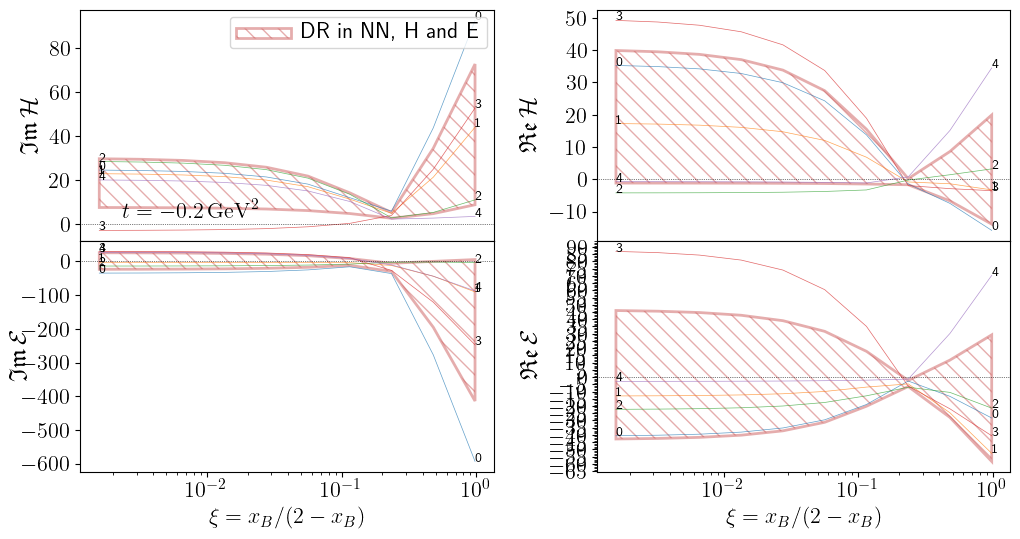

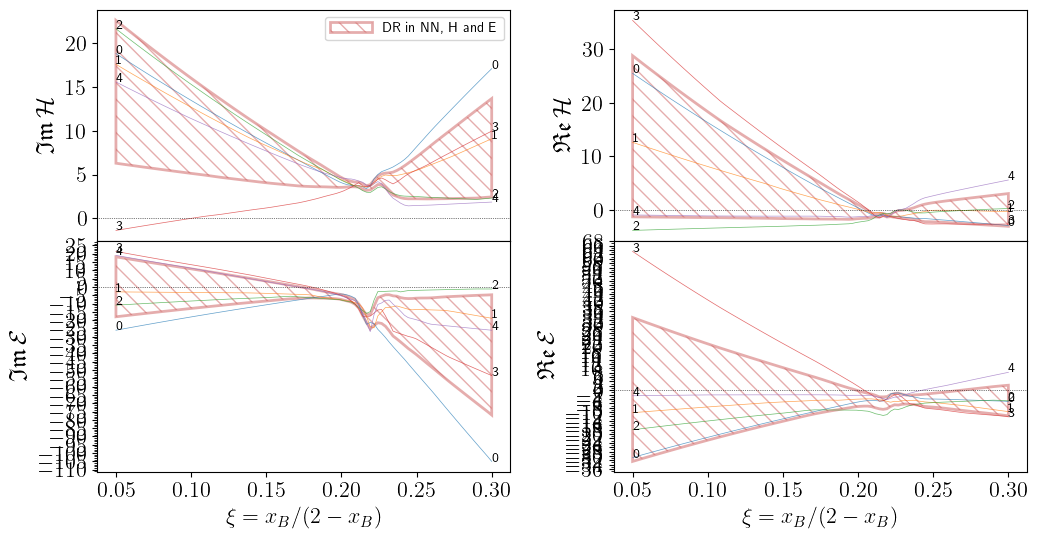

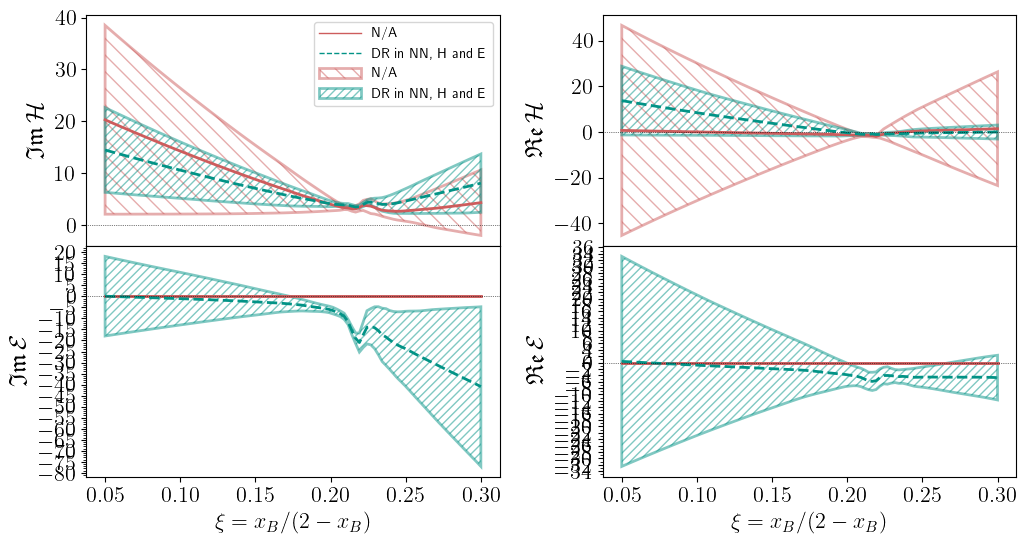

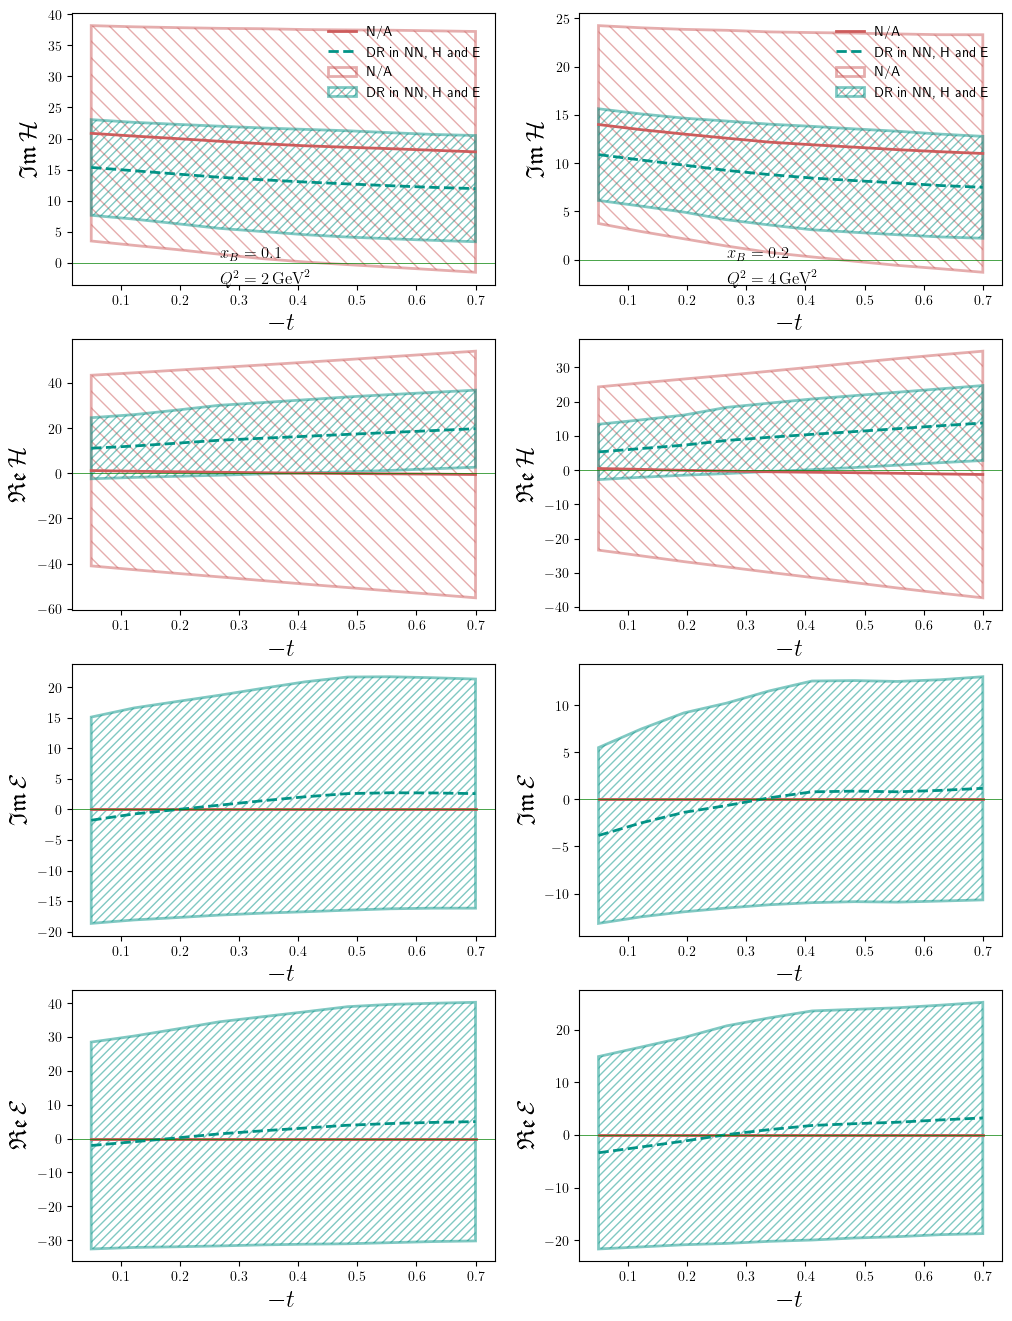

In [73]:
th2.name = "DR in NN, H and E"
fig = gplot.CFF3log(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  mesh=th2, bands=[th2], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  mesh=th2, bands=[th2])
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th, th2], bands=[th, th2])
fig = gplot.CFFt(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th, th2], bands=[th, th2])

In [74]:
th2.chisq(fitpoints)

(np.float64(83.89750653213906), 112, np.float64(0.9781576704322675))

## Custom NN

In [75]:
import torch.nn as nn
class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()

        # Define the layers for the network
        self.n1 = nn.Linear(2, 23)  # 2 input features, 12 hidden units
        self.n2 = nn.Linear(23, 37)  # 12 hidden units, 17 hidden units
        self.n3 = nn.Linear(37, 1)  # 7 hidden units, 1 output features
        
        self.n1p = nn.Linear(1, 7)  # 2 input features, 12 hidden units
        self.n2p = nn.Linear(7, 5)  # 12 hidden units, 17 hidden units
        self.n3p = nn.Linear(5, 1)  # 17 hidden units, 1 output features

    def forward(self, x):
        
       
        x0 = x
        
        # Build Im network
        x = torch.relu(self.n1(x0))
        x = torch.relu(self.n2(x))
        output1 = self.n3(x)
        
        # Build D network
        # build the input tensor
        x0_1 = torch.cat((x0[:,1].unsqueeze(1),), dim=0)
       
        x2 = torch.relu(self.n1p(x0_1))
        x2 = torch.relu(self.n2p(x2))
        output2 = self.n3p(x2)
        
        #concatenate outputs
        output = torch.cat((output1, output2), dim=1)
       
        return output 

### Create the class inheriting from DispersionCFF

In [ ]:
class NNTest_DR(g.model.NeuralModel_DR, g.eff.DipoleEFF, g.dvcs.BM10tw2, g.cff.DispersionCFF):
    
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = CustomNetwork()
        optimizer = torch.optim.Rprop(nn_model.parameters(),
                lr=0.01)
        return nn_model, optimizer
    
    def subtraction(self, pt): #This should use the NN, the real part will be calculated by the CFF_Dispersion methods
        """Subtraction constant."""
        #refer to the location of D in output layer (defined in the next cell)
        xi = pt.xB / (2 - pt.xB)
        return self.cffs(1, pt, xi)
    
    def ImH(self, pt, xi=0) -> float:
        """Return Im(CFF H) for kinematic point."""
        #refer to the location of Im H in output layer (defined in the next cell)
        return self.cffs(0, pt, xi)
    
    def ImE(self, pt, xi=0):
        """Return Im(CFF E) for kinematic point."""
        return self.zero(pt)
    
    def ImHt(self, pt, xi=0):
        """Return Im(CFF Ht) for kinematic point."""
        return self.zero(pt)
    
    def ImEt(self, pt, xi=0):
        """Return Im(CFF Et) for kinematic point."""
        return self.zero(pt)

In [77]:
th2 = NNTest_DR(output_layer=['ImH', 'D'])#'ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt'])#

In [ ]:
import time
t0 = time.time()

#f = g.fitter.NeuralFitter(fitpoints, th2, nnets=3, nbatch=10, batchlen=4, regularization='None', lx_lambda=0.001)
f = g.fitter.NeuralFitter(fitpoints, th2, nnets=5, batchlen=10, regularization='L2', lx_lambda=0.002)
f.fit()
#torch.save(th2.nets, 'Test_dataset2_nets.tar')

t1 = time.time()
# time in minutes
print(f"Total time: {(t1 - t0) / 60:.2f} minutes")


Epoch  10: train error = 30.3873 test error = 28.8809 -
Epoch  20: train error = 17.3224 test error = 21.9035 -
Epoch  30: train error = 9.6168 test error = 7.9353 -
Epoch  40: train error = 9.0801 test error = 8.1058 +
Epoch  50: train error = 8.4694 test error = 10.4223 +
Epoch  60: train error = 8.0687 test error = 14.3852 +
Epoch  70: train error = 7.7489 test error = 14.5009 +
Epoch  80: train error = 7.5687 test error = 14.6301 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 7.935344427540887

Epoch  10: train error = 62.9062 test error = 88.2743 -
Epoch  20: train error = 33.9016 test error = 46.0951 -
Epoch  30: train error = 16.3309 test error = 13.9327 -
Epoch  40: train error = 9.5950 test error = 11.1251 -
Epoch  50: train error = 7.9680 test error = 12.9361 +
Epoch  60: train error = 7.6309 test error = 12.7638 +
Epoch  70: train error = 7.5087 test error = 13.4706 +
Epoch  80: train error = 7.4375 test error = 13.5697 +
Epoch  90: train error = 7.368

In [80]:
th2.chisq(fitpoints)

(np.float64(684.0989294504241), 112, np.float64(0.0))

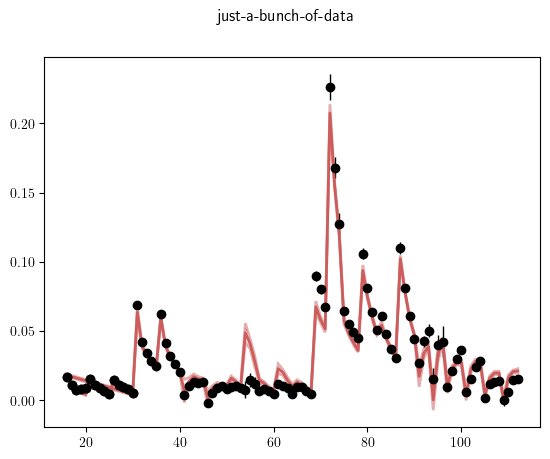

In [81]:
fig = gplot.jbod(points=fitpoints, lines=[th2], bands=[th2])

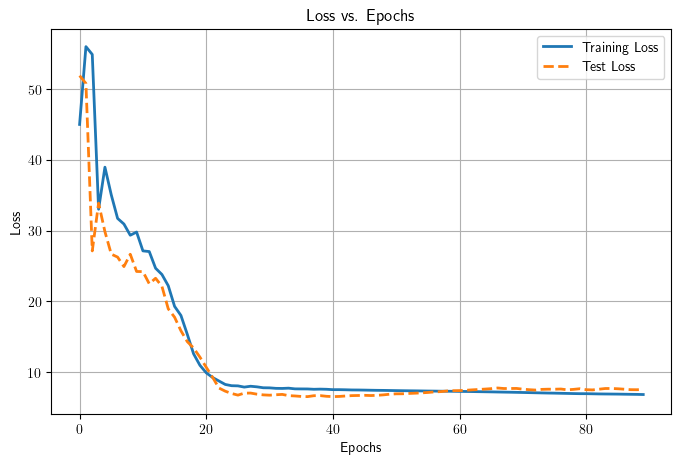

In [83]:
# Plot the results:
plt.figure(figsize=(8, 5))
plt.plot(f.history, label="Training Loss",linewidth=2.0)
plt.plot(f.test_history, label="Test Loss", linestyle="dashed",linewidth=2.0)
plt.xlabel("Epochs") #Epochs in nbatch length
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()
plt.grid()
plt.show()

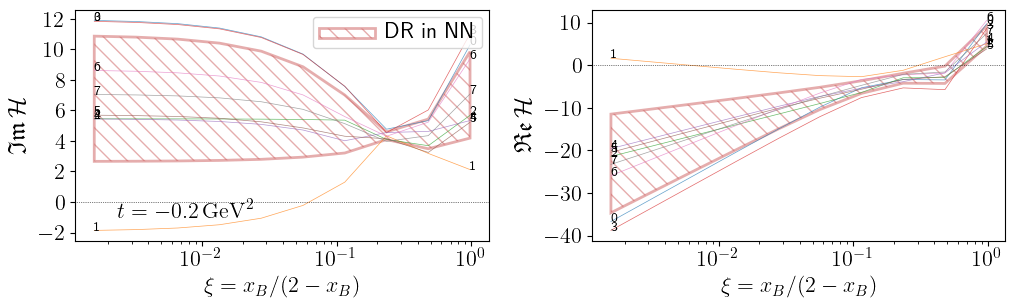

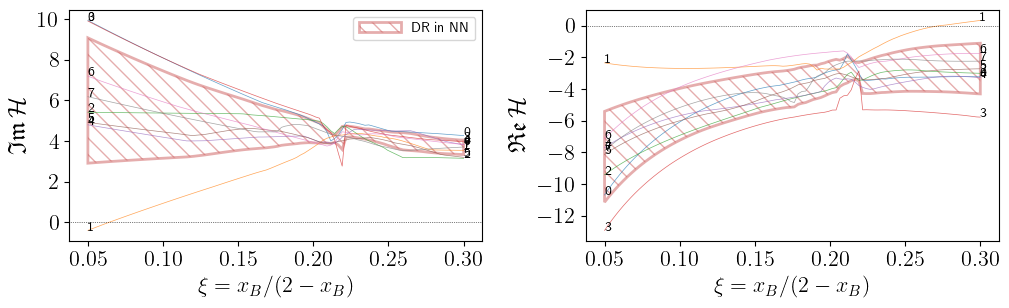

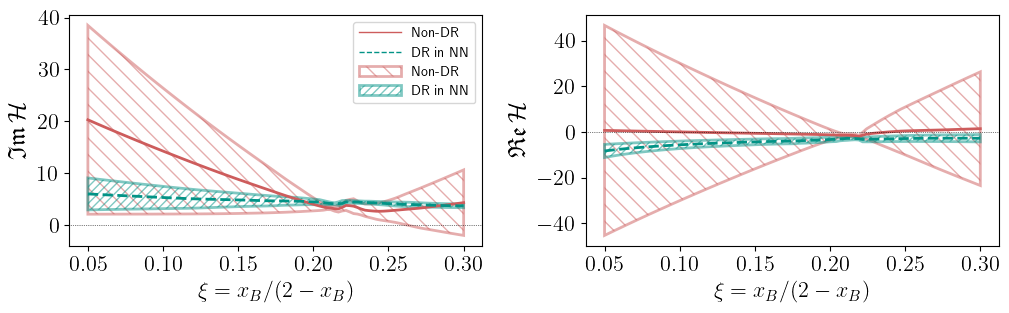

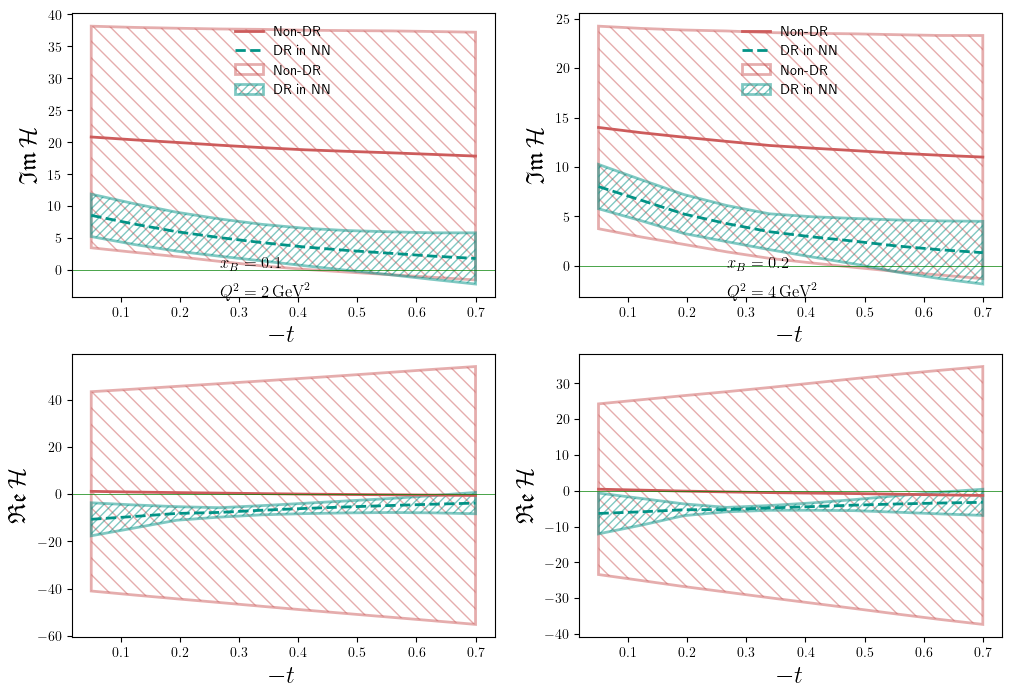

In [85]:
th.name = "Non-DR"
th2.name = "DR in NN"
fig = gplot.CFF3log(cffs=['ImH', 'ReH'],  mesh=th2, bands=[th2], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  mesh=th2, bands=[th2])
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  lines=[th, th2], bands=[th, th2])
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=[th, th2], bands=[th, th2])

## Test with 4 CFFs

In [11]:
import torch.nn as nn
class CustomNetwork_4(nn.Module):
    def __init__(self):
        super(CustomNetwork_4, self).__init__()

        # Define the layers for the network
        self.n1 = nn.Linear(2, 23)  # 2 input features, 7 hidden units
        self.n2 = nn.Linear(23, 37)  # 7 hidden units, 7 hidden units
        self.n3 = nn.Linear(37, 2)  # 7 hidden units, 2 output features
        
        self.n1p = nn.Linear(1, 7)  # 2 input features, 7 hidden units
        self.n2p = nn.Linear(7, 5)  # 7 hidden units, 7 hidden units
        self.n3p = nn.Linear(5, 1)  # 7 hidden units, 2 output features

    def forward(self, x):
        
       
        x0 = x
        
        # Build Im network
        x = torch.relu(self.n1(x0))
        x = torch.relu(self.n2(x))
        output1 = self.n3(x)
        
        # Build D network
        # build the input tensor
        x0_1 = torch.cat((x0[:,1].unsqueeze(1),), dim=0)
       
        x2 = torch.relu(self.n1p(x0_1))
        x2 = torch.relu(self.n2p(x2))
        output2 = self.n3p(x2)
        
        #concatenate outputs
        output = torch.cat((output1, output2), dim=1)
       
        return output 

In [12]:
class NNTest_DR_4(g.model.NeuralModel_DR, g.eff.DipoleEFF, g.dvcs.BM10tw2, g.cff.DispersionCFF):
    
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = CustomNetwork_4()
        optimizer = torch.optim.Rprop(nn_model.parameters(),
                lr=0.05) # lr=0.01
        return nn_model, optimizer
    
    def subtraction(self, pt): #This should use the NN, the real part will be calculated by the CFF_Dispersion methods
        """Subtraction constant."""
        #print("I am here in D")
        xi = pt.xB / (2 - pt.xB)
        #refer to the location of D in output layer (defined in the next cell)
        return self.cffs(2, pt, xi)
    
    def ImH(self, pt, xi=0) -> float:
        """Return Im(CFF H) for kinematic point."""
        #refer to the location of Im H in output layer (defined in the next cell)
        return self.cffs(0, pt, xi)
    
    def ImE(self, pt, xi=0):
        """Return Im(CFF E) for kinematic point."""
        return self.cffs(1, pt, xi)
    
    def ImHt(self, pt, xi=0):
        """Return Im(CFF Ht) for kinematic point."""
        return self.zero(pt)
    
    def ImEt(self, pt, xi=0):
        """Return Im(CFF Et) for kinematic point."""
        return self.zero(pt)

In [13]:
th3 = NNTest_DR_4(output_layer=['ImH', 'ImE', 'D'])

In [16]:
#f = g.fitter.NeuralFitter(fitpoints, th3, nnets=5, nbatch=10, batchlen=2, regularization='L2', lx_lambda=0.0001)
f = g.fitter.NeuralFitter(fitpoints, th3, nnets=5, batchlen=10, regularization='L2', lx_lambda=0.002)
f.fit()
#torch.save(th3.nets, 'Test_dataset3_nets.tar')


Epoch  10: train error = 2.9082 test error = 2.4919 -

KeyboardInterrupt: 

In [106]:
th3.chisq(fitpoints)

(np.float64(211.7149123754012), 112, np.float64(3.9134514295824374e-08))

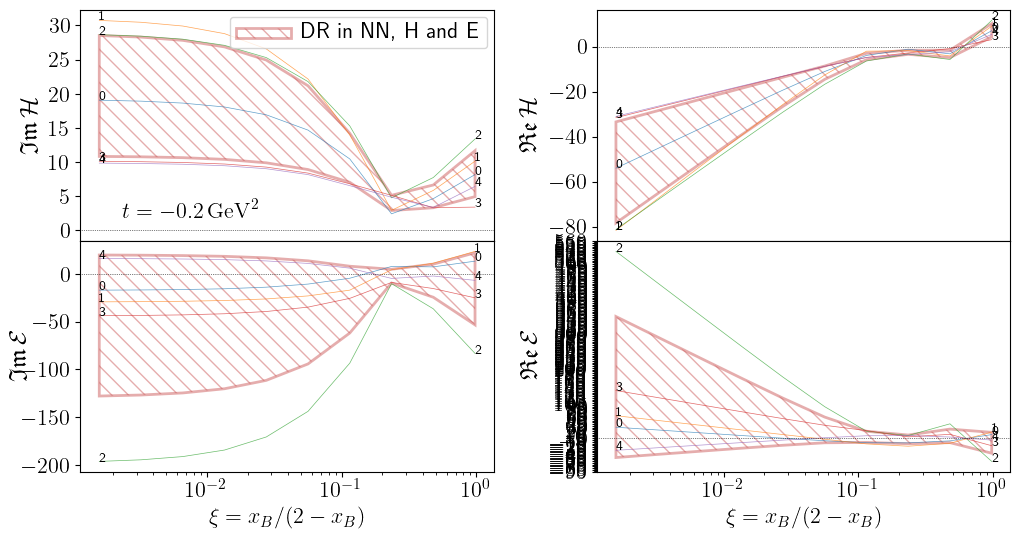

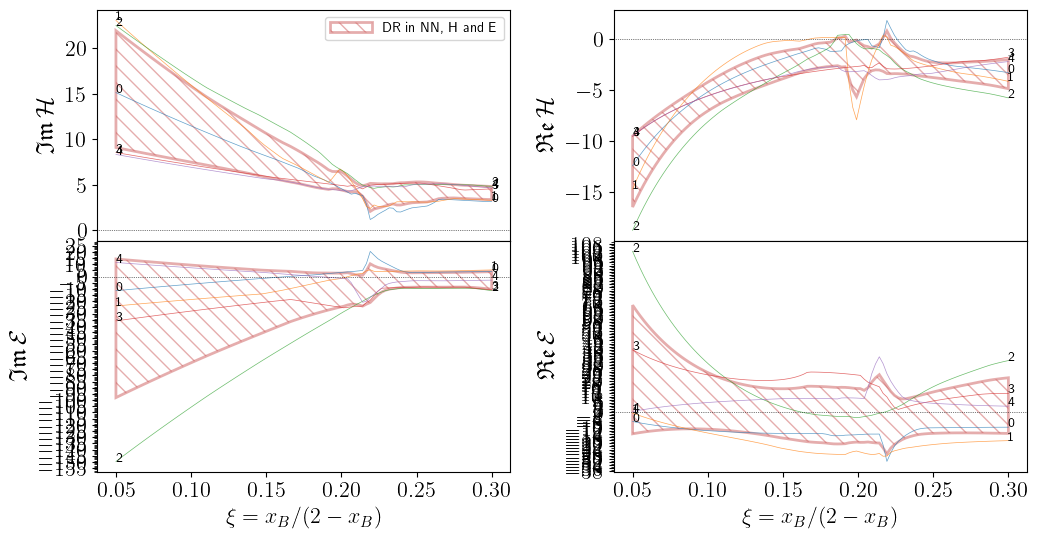

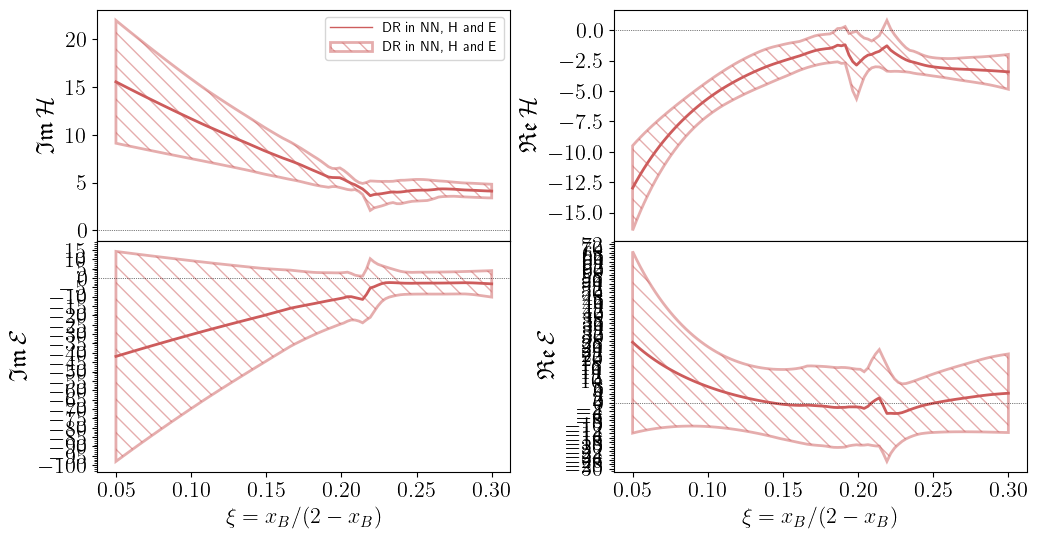

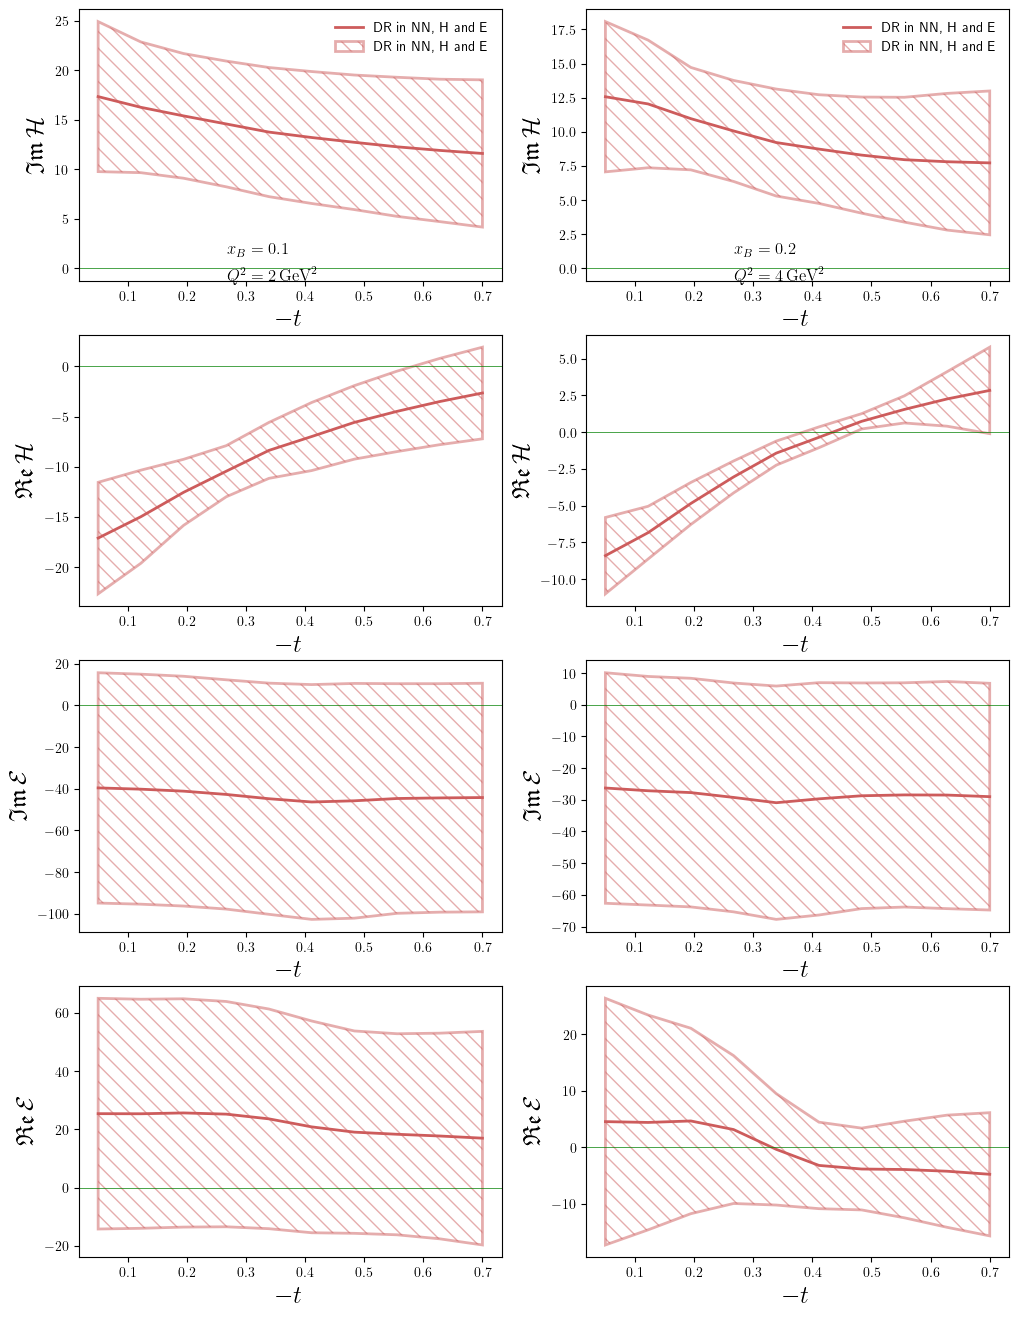

In [107]:
#th.name = "No DR"
#th2.name = "DR in NN"
th3.name = "DR in NN, H and E"
fig = gplot.CFF3log(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  mesh=th3, bands=[th3], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  mesh=th3, bands=[th3])
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th3], bands=[th3])  #lines=[th, th2, th3], bands=[th, th2, th3]
fig = gplot.CFFt(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th3], bands=[th3])  #lines=[th, th2, th3], bands=[th, th2, th3]

### Describing CLAS data of 2015

KeyboardInterrupt: 

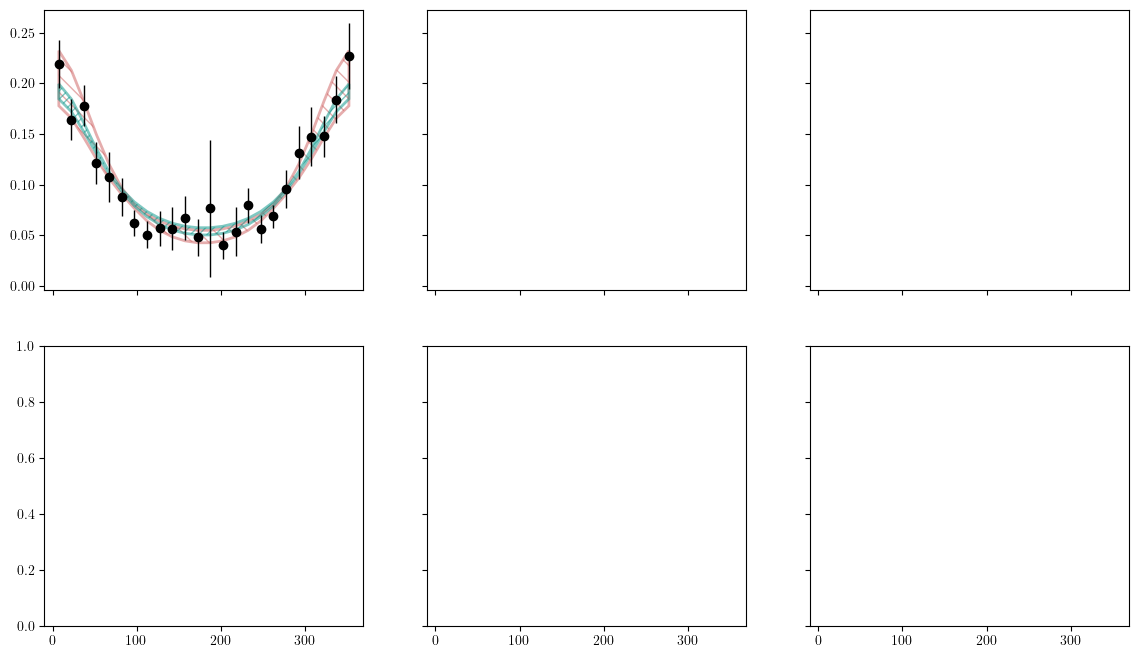

In [108]:
fig = plots.CLAS15phi(bands=[th,th2,th3])

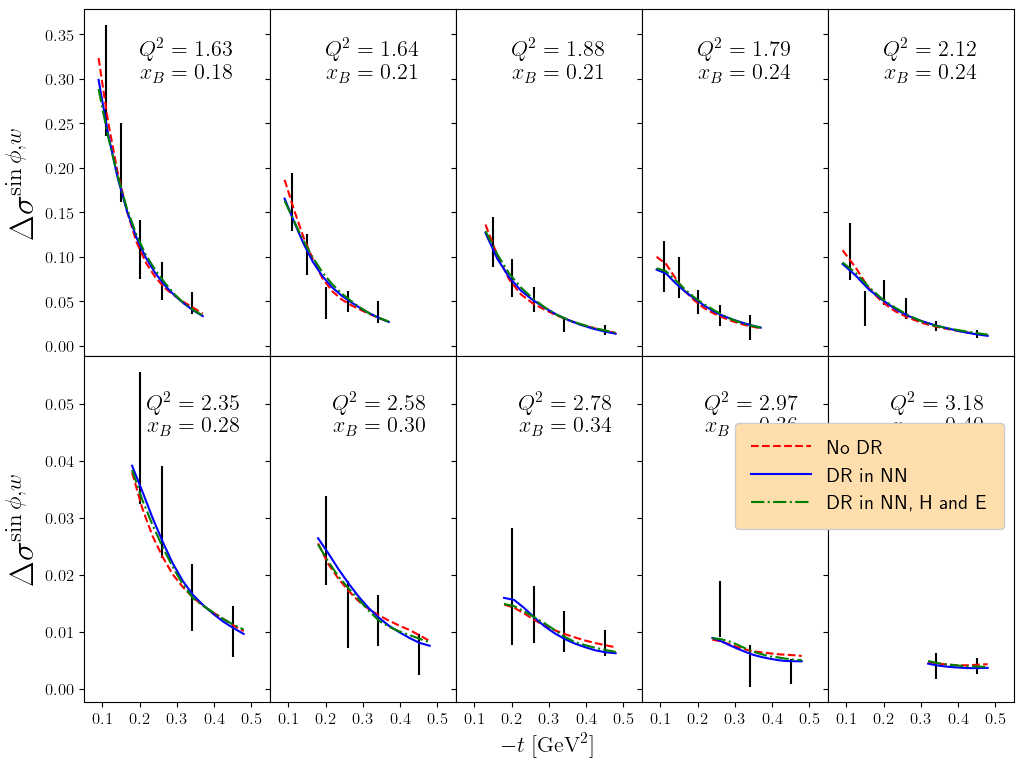

In [ ]:
fig = gplot.CLAS15xs(lines=[th,th2,th3])

## D-term using NN

In [ ]:
import random
ptts = []
tm_list = np.linspace(0.1, 0.5, 10)#[0.1, 0.2, 0.3, 0.4]

for tm in tm_list:
    #rndm_idx = random.randint(0, len(tm_list)-1) # take some random point and set/change -t
    ptb = g.dset[102][0].copy()  
    ptb.t = -tm
    ptb.tm = tm
    th15.prepare(ptb)
    ptts.append(ptb)


print(ptts)

[DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437]


In [ ]:
th2.name = "DR in NN whit 2 CFFs"
th3.name = "DR in NN with 4 CFFs"

In [ ]:
D = []
std_values = [] #!
net_indices = [] #!
for th in [th2, th3]: #[th2]: 
    print("\n---- [{} - {}] ----".format(th.name, th.description))
    A = []
    for pt in ptts[::-1]:
        Ds = []
        for i, net in enumerate(th.nets):  # Loop over neural networks
            th.nn_model, th.nn_mean, th.nn_std = net  # Assign neural net parameters
            
            Ds.append(float(th.m.subtraction(pt).detach().numpy()*18./25.))
            #print(float(-th.m.subtraction(pt).detach().numpy()*18./25.))
            th.cffs_evaluated = False
        net_indices.append(i)
        #for k in range(len(th.m.nets)):
            #th.m.parameters['nnet'] = k
            # NOTE: subtraction in code is equal to -\Delta(t) !
            #Ds.append(-th.m.subtraction(pt).detach().numpy()*18./25.) 
            #print(-th.m.subtraction(pt).detach().numpy()*18./25.)
        Ds = np.array(Ds)
        D_std = Ds.std() #!
        std_values.append(D_std) #!

        print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), Ds.std()))
        A.append((pt.tm, Ds.mean(), Ds.std()))
    th.m.parameters['nnet'] = 'ALL'    
    D.append(A)


---- [DR in NN whit 2 CFFs - N/A] ----
0.185, -0.5: -0.4780326887965202 +- 1.4773601863785928
0.185, -0.4555555555555556: -0.6362771719694138 +- 1.329302059053012
0.185, -0.4111111111111111: -0.7882916733622551 +- 1.1722124111284176
0.185, -0.3666666666666667: -0.882777250930667 +- 1.132817425052218
0.185, -0.32222222222222224: -0.9457036584615708 +- 1.1563550731254926
0.185, -0.2777777777777778: -0.9580904725007713 +- 1.1988336336453773
0.185, -0.23333333333333334: -1.1669922083616258 +- 1.295013604717738
0.185, -0.18888888888888888: -1.552262084186077 +- 1.4937359475849563
0.185, -0.14444444444444446: -1.970478953793645 +- 1.7274276258180312
0.185, -0.1: -2.383175742998719 +- 2.0401277230855293

---- [DR in NN with 4 CFFs - N/A] ----
0.185, -0.5: -0.8183236420154572 +- 1.2069137187002965
0.185, -0.4555555555555556: -0.8466813564300537 +- 1.0012454716220371
0.185, -0.4111111111111111: -0.8918539864942432 +- 0.7746504280677209
0.185, -0.3666666666666667: -0.9252635538578033 +- 0.56977

/var/folders/qr/2k2591d90wjb4sqtmlttw7r40000gq/T/ipykernel_55934/1427647854.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ds.append(float(th.m.subtraction(pt).detach().numpy()*18./25.))


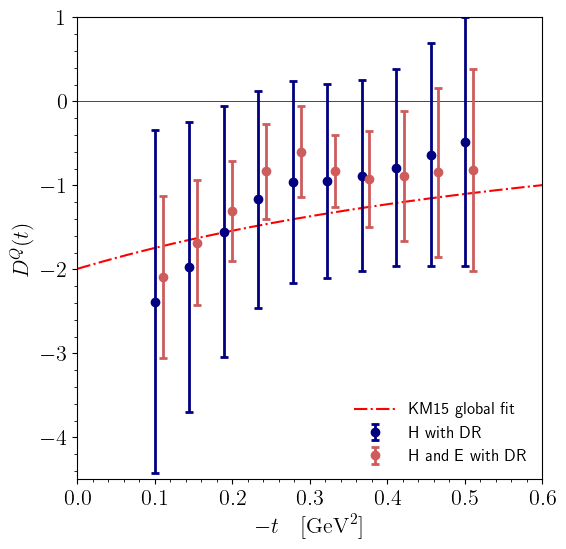

In [ ]:
NPTS = 20
ts = np.linspace(0, 0.6, NPTS)
KMS = np.array([-(18./25.)*2.768/(1.+tm/1.204**2)**2 for tm in ts])
CDS = np.array(D[0])
CADS = np.array(D[1])
fig, ax = plt.subplots(1, 1,  figsize=[6,6])
ax.axhline(y=0, linewidth=0.5, color='k')  # y=0 thin line
ax.plot(ts, KMS, 'r-.', label='KM15 global fit')
ax.errorbar(CDS[:,0], CDS[:,1], CDS[:,2], linestyle='None', color='navy',
            elinewidth=2, capsize=3, capthick=2, marker='o', label='H with DR')
ax.errorbar(CADS[:,0,]+0.01, CADS[:,1], CADS[:,2], linestyle='None', elinewidth=2,
            capsize=3, capthick=2, marker='o', color='indianred', label='H and E with DR')

ax.set_xlim(0.0, 0.6)
ax.set_ylim(-4.5, 1)
ax.legend(loc=4, handlelength=2.5,
            prop=matplotlib.font_manager.FontProperties(size="large")
        ).draw_frame(0)
ax.set_xlabel(r'$-t \quad [{\rm GeV}^2]$', fontsize=16)
ax.set_ylabel(r'$D^{Q}(t)$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)) 
ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.02)) 
ax.yaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(1.)) 
ax.yaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.2)) 